In [1]:
import numpy as np
from collections import Counter
import pickle as pkl
import random
import pdb
import pandas as pd
import string
import re
import unicodedata
import os
import time
import math

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.nn import functional

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
%matplotlib inline

#specify SOS() and EOS(end of sentence)
#specify maximum vocabulary size = 50000
PAD_IDX = 2
UNK_IDX = 3
SOS_token = 0
EOS_token = 1
MAX_VOCAB_SIZE = 50000
MAX_LENGTH = 30

train_en = '/data/train.tok.en'
train_zh = '/data/train.tok.zh'
val_en = '/data/dev.tok.en'
val_zh = '/data/dev.tok.zh'


In [2]:
#user GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    print("Currently using GPU")

In [3]:
folder_path = os.getcwd()

Load Pre-Trained Embedding Matrix

In [5]:
def load_emb_matrix(language):
    #load fasttext word vectors
    words_to_load = MAX_VOCAB_SIZE
    if language == 'english':
        file = 'wiki-news-300d-1M-subword.vec'
    if language == 'chinese':
        file = 'cc.zh.300.vec'
    

    with open(folder_path + 'data/' + file) as f:
        #remove the first line
        firstLine = f.readline()
        loaded_embeddings = np.zeros((words_to_load + 4, 300))
        words2id = {}
        idx2words = {}
        #ordered_words = []
        for i, line in enumerate(f):
            if i >= words_to_load: 
                break
            s = line.split()
            loaded_embeddings[i + 4 , :] = np.asarray(s[1:])
            words2id['<SOS>'] = SOS_token
            words2id['<EOS>'] = EOS_token
            words2id['<pad>'] = PAD_IDX
            words2id['<unk>'] = UNK_IDX
            words2id[s[0]] = i + 4
            
            idx2words[0] = '<SOS>'
            idx2words[1] = '<EOD>'
            idx2words[2] = '<pad>'
            idx2words[3] = '<unk>'
            
            idx2words[i + 4] = s[0]
   

    return words2id,idx2words,loaded_embeddings

In [6]:
def generate_weights_matrix(idx2words,loaded_embeddings):
   
    matrix_len = len(idx2words)
    weights_matrix = np.zeros((matrix_len, 300))
    
    for key in idx2words.keys():
        try: 
            weights_matrix[key] = loaded_embeddings[key]
        except KeyError:
            weights_matrix[key] = np.random.normal(scale=0.6, size=(emb_dim, ))
    return weights_matrix

In [0]:
words2id_eng,idx2words_eng,loaded_embeddings_eng = load_emb_matrix('english')
words2id_zh,idx2words_zh,loaded_embeddings_zh = load_emb_matrix('chinese')

pkl.dump(words2id_eng, open(folder_path + 'data/words2id_eng.pkl', 'wb'))
pkl.dump(idx2words_eng, open(folder_path +'data/idx2words_eng.pkl', 'wb'))
pkl.dump(loaded_embeddings_eng, open(folder_path +'data/embedding_matrix_eng.pkl', 'wb'))

pkl.dump(words2id_zh, open(folder_path + 'data/words2id_zh.pkl', 'wb'))
pkl.dump(idx2words_zh, open(folder_path + 'data/idx2words_zh.pkl', 'wb'))
pkl.dump(loaded_embeddings_zh, open(folder_path +'data/embedding_matrix_zh.pkl', 'wb'))


In [0]:
weights_matrix_eng = generate_weights_matrix(idx2words_eng,loaded_embeddings_eng)
pkl.dump(weights_matrix_eng, open(folder_path + 'data/weights_matrix_eng.pkl', 'wb'))
weights_matrix_eng = torch.from_numpy(weights_matrix_eng).to(device)

weights_matrix_zh = generate_weights_matrix(idx2words_zh,loaded_embeddings_zh)
pkl.dump(weights_matrix_zh, open(folder_path + 'data/weights_matrix_zh.pkl', 'wb'))
weights_matrix_zh = torch.from_numpy(weights_matrix_zh).to(device)

In [7]:
words2id_eng = pkl.load(open(folder_path + "/data/words2id_eng.pkl", "rb"))
idx2words_eng = pkl.load(open(folder_path +"/data/idx2words_eng.pkl", "rb"))
loaded_embeddings_eng = pkl.load(open(folder_path +"/data/embedding_matrix_eng.pkl", "rb"))
words2id_zh = pkl.load(open(folder_path + "/data/words2id_zh.pkl", "rb"))
idx2words_zh = pkl.load(open(folder_path +"/data/idx2words_zh.pkl", "rb"))
loaded_embeddings_zh = pkl.load(open(folder_path +"/data/embedding_matrix_zh.pkl", "rb"))

weights_matrix_eng = pkl.load(open(folder_path +"/data/weights_matrix_eng.pkl", "rb"))
weights_matrix_eng = torch.from_numpy(weights_matrix_eng).to(device)
weights_matrix_zh = pkl.load(open(folder_path +"/data/weights_matrix_zh.pkl", "rb"))
weights_matrix_zh = torch.from_numpy(weights_matrix_zh).to(device)

Read Languages

In [8]:
#define a class of language
class Language:
    def __init__(self, name,word2index,index2word):
        self.name = name
        self.word2index = word2index
        #self.word2count = {}
        self.index2word = index2word
        self.n_words = len(word2index)



In [9]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = s.replace(r"&quot;","")
    s = s.replace(r"&apos;","'")
    s = unicodeToAscii(s.strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s
  

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [10]:
#To read the data file we will split the file into lines, and then split lines into pairs. 

def readLanguages(input_lang,target_lang):
    print("\nReading lines...")

    # Read the file and split into lines
    input_lines = open(folder_path + input_lang, encoding='utf-8').\
        read().strip().split('\n')
    target_lines = open(folder_path + target_lang, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line and normalize
    #for chinese input, strip the space at the begining and end of the sentence
    #for english output, use normalizeString function
    input_lines_norm = [l.strip() for l in input_lines]
    target_lines_norm = [normalizeString(l) for l in target_lines]
    
    #build pairs
    #drop pair if both zh and en are empty strings
    pairs = [[item[0],item[1]] for item in zip(input_lines_norm,target_lines_norm) if len(item[0])+len(item[1]) != 0]
    
    input_lines = Language("zh",words2id_zh,idx2words_zh)
    target_lines = Language("en",words2id_eng,idx2words_eng)

    return input_lines, target_lines, pairs

In [11]:
def prepareData(input_lang, target_lang):
    input_lang, output_lang, pairs = readLanguages(input_lang, target_lang)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
#     for pair in pairs:
#         input_lang.addSentence(pair[0])
#         output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    return input_lang, output_lang, pairs



Preparing Data
========

In [22]:
train_input_lang, train_output_lang, train_pairs = prepareData(train_zh, train_en)
print("print a random pair of training pairs:")
print(random.choice(train_pairs))



val_input_lang, val_output_lang, val_pairs = prepareData(val_zh, val_en)
print("print a random pair of validation pairs:")
print(random.choice(val_pairs))


# pkl.dump(train_input, open(folder_path +'data/train_input.pkl', 'wb'))
# pkl.dump(train_output, open(folder_path +'data/train_output.pkl', 'wb'))
# pkl.dump(train_pairs, open(folder_path +'data/train_pairs.pkl', 'wb'))
# pkl.dump(val_input, open(folder_path +'data/val_input.pkl', 'wb'))
# pkl.dump(val_output, open(folder_path +'data/val_output.pkl', 'wb'))
# pkl.dump(val_pairs, open(folder_path +'data/val_pairs.pkl', 'wb'))


Reading lines...
Read 213237 sentence pairs
Trimmed to 156070 sentence pairs
Counting words...
Counted words:
zh 50004
en 50004
print a random pair of training pairs:
['这 是 第一 第一个 一个 演示', 'Here s the first demonstration .']

Reading lines...
Read 1261 sentence pairs
Trimmed to 848 sentence pairs
Counting words...
Counted words:
zh 50004
en 50004
print a random pair of validation pairs:
['同时   沥青 沥青路 会 产生 很大 噪音', 'Also asphalt can create a lot of noise .']


## Build DataLoader for minibatch

In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] if word in lang.word2index else UNK_IDX for word in sentence.split(' ')] + [EOS_token]

In [23]:
BATCH_SIZE = 32

class VocabDataset(Dataset):
    """
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, pairs,input_language, output_language):
        """
        @param pairs: pairs of input and target sentences(raw text sentences)
        @param input_language: Class Lang of input languages (zh in this case)
        @param output_language: Class Lang of output languages (en in this case)

        """
        self.pairs = pairs
        self.inputs = [pair[0] for pair in pairs]
        self.input_lang = input_language
        self.output_lang = output_language
        self.outputs = [pair[1] for pair in pairs]
        
        
        #assert self.input_lang == self.target_lang
       
    def __len__(self):
         return len(self.pairs)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        #turn raw text sentecens into indices
        input_ = indexesFromSentence(self.input_lang, self.inputs[key])
        output = indexesFromSentence(self.output_lang, self.outputs[key])
        
        #print both the length of the source sequence and the target sequence
        return [input_,len(input_),output,len(output)]
    
    
    def __gettext__(self,key):
        return [self.inputs[key],self.outputs[key]]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    input_data_list = []
    output_data_list = []
   
    
    for datum in batch:
        input_data_list.append(datum[0])
        output_data_list.append(datum[2])
      
      
    # Zip into pairs, sort by length (descending), unzip
    seq_pairs = sorted(zip(input_data_list, output_data_list), key=lambda p: len(p[0]), reverse=True)
    input_seqs, output_seqs = zip(*seq_pairs)
    
    #store the length of the sequences 
    input_data_len = [len(p) for p in input_seqs]
    output_data_len = [len(p) for p in output_seqs]
    
    #padding
    padded_vec_input = [np.pad(np.array(p),
                                 pad_width=((0,MAX_LENGTH-len(p))),
                                 mode="constant", constant_values=0) for p in input_seqs]
        
    padded_vec_output = [np.pad(np.array(p),
                                 pad_width=((0,MAX_LENGTH-len(p))),
                                 mode="constant", constant_values=0) for p in output_seqs]      
    
    
    input_var = Variable(torch.LongTensor(padded_vec_input))
    output_var = Variable(torch.LongTensor(padded_vec_output))
    input_data_len = Variable(torch.LongTensor(input_data_len))
    output_data_len = Variable(torch.LongTensor(output_data_len))
    
    
    return [input_var,input_data_len,output_var,output_data_len]
   

   

In [24]:
# Build train and valid dataloaders

train_dataset = VocabDataset(train_pairs,train_input_lang, train_output_lang)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True,
                                           drop_last = True)


val_dataset = VocabDataset(val_pairs,val_input_lang,val_output_lang)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False,
                                         drop_last = True)



Building Neural Networks (Encoder & Decoder)
-----------

The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, weights_matrix, input_size, hidden_size,n_layers=1):
        super(EncoderRNN, self).__init__()
     
        
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.n_layers = n_layers
        self.batch_size = BATCH_SIZE
        self.num_embeddings, self.embedding_dim = weights_matrix.size()
        
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.copy_(weights_matrix)
        self.embedding.weight.requires_grad = False

        
        self.gru = nn.GRU(self.embedding_dim, hidden_size, n_layers, bidirectional=True)
        

    def forward(self, input_seqs, input_len, hidden=None):

       
        embedded = self.embedding(input_seqs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_len)
        output, hidden = self.gru(packed, hidden)

        output, output_len = torch.nn.utils.rnn.pad_packed_sequence(output)
        output = output[:, :, :self.hidden_size] + output[:, : ,self.hidden_size:]
        
        return output,hidden
      

   

In [66]:
class CNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers, kernel_size):

        super(CNN, self).__init__()

        num_embeddings, embedding_dim = weights_matrix.size()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim,padding_idx=PAD_IDX)
        self.embedding.weight.data.copy_(weights_matrix)
        self.embedding.weight.requires_grad = False
        
        #out: dim = []
        self.layer = nn.Sequential(
            nn.Conv1d(embedding_dim, hidden_size, kernel_size = kernel_size, padding=PAD_IDX),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = (MAX_LENGTH - kernel_size + 1),padding = PAD_IDX))
        
        self.fc = nn.Linear(hidden_size, 180)
        
        self.layer = self.layer.to(device)
        self.fc = self.fc1.to(device)

        
        
    def forward(self, input_seq):
        # size: [batch_size,seq_length,hidden_size]
        embed = self.embedding(input_seq).to(device)
        #in: dim = [batch_size_x, hidden_size, seq_length_length](after transpose)
        #out: dim = []
        hidden = self.layer(embed.transpose(1,2))

        out = hidden.reshape(hidden.size(0), -1)
        out = self.fc(out)
        out = F.relu(out.contiguous().view(-1, out.size(-1)))

        
        return out,hidden

Decoder w/o Attention
------------------------
In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder's last hidden state).

In [40]:
class DecoderRNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, output_size,n_layers=1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        #self.batch_size = BATCH_SIZE
        self.num_embeddings, self.embedding_dim = weights_matrix.size()
        
        #self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.copy_(weights_matrix)
        self.embedding.weight.requires_grad = False
        
        self.gru1 = nn.GRU(self.embedding_dim, hidden_size,n_layers)
        self.gru2 = nn.GRU(hidden_size, hidden_size,n_layers)
        
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_seq, hidden):
        
        embedded = self.embedding(input_seq) # dim = Batch_Size x embedding_dim
        embedded = embedded.view(1, embedded.size(0), self.embedding_dim) # S=1 x Batch_Size x embedding_dim
        
        rnn_output, hidden = self.gru1(embedded, hidden)
        output = F.relu(rnn_output)
        
        output, hidden = self.gru2(output, hidden)
        output = self.softmax(self.out(output[0]))
        
        return output,hidden



    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size).to(device)

Attention Decoder
----------------

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.


In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, output_size, n_layers=1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.max_length = max_length
        self.batch_size = BATCH_SIZE
        self.num_embeddings, self.embedding_dim = weights_matrix.size()

        #self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.copy_(weights_matrix)
        self.embedding.weight.requires_grad = False
        
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
       
        self.gru1 = nn.GRU(self.embedding_dim, hidden_size,n_layers)
        self.gru2 = nn.GRU(hidden_size, hidden_size,n_layers)
        
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq, hidden, encoder_outputs):
        embedded = self.embedding(input_seq).view(1, 1, -1)
 

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size).to(device)

In [0]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))
     
    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(this_batch_size, max_len)).to(device) # Batch_Size x Seq_Length

        
#         # For each batch of encoder outputs
        for b in range(this_batch_size):
            # Calculate energy for each encoder output
            for i in range(max_len):
                attn_energies[b, i] = self.score(hidden[:, b], encoder_outputs[i, b].unsqueeze(0))

        # Normalize energies to weights in range 0 to 1, resize to 1 x B x S
        return F.softmax(attn_energies,dim=1).unsqueeze(1)
      
    def score(self, hidden, encoder_output):
        
        if self.method == 'dot':
            energy = hidden.dot(encoder_output)
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = torch.mm(hidden, energy.transpose(0,1))
            return energy
        
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = self.v.dot(energy)
            return energy

In [0]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, weights_matrix, hidden_size, output_size, n_layers=1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.batch_size = BATCH_SIZE
        self.num_embeddings, self.embedding_dim = weights_matrix.size()


        # Define layers
        #self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.copy_(weights_matrix)
        self.embedding.weight.requires_grad = False
        
        
        self.gru1 = nn.GRU(self.embedding_dim, hidden_size,n_layers)
        self.gru2 = nn.GRU(hidden_size, hidden_size,n_layers)
        
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):
        # Note: we run this one step at a time

        # Get the embedding of the current input word (last output word)

        embedded = self.embedding(input_seq) # dim = Batch_Size x embedding_dim
        embedded = embedded.view(1, self.batch_size, self.embedding_dim) # S=1 x Batch_Size x embedding_dim

        # Get current hidden state from input word and last hidden state
        # rnn_output : [1 x batch_size x hidden_size]
        # hidden: [layer x batch_size x hidden_size]
        rnn_output, hidden = self.gru1(embedded, last_hidden)
        
        # Calculate attention from current RNN state and all encoder outputs;
        # apply to encoder outputs to get weighted average
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x S=1 x N

        # Attentional vector using the RNN hidden state and context vector
        # concatenated together (Luong eq. 5)
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))

        # Finally predict next token (Luong eq. 6, without softmax)
        output = self.out(concat_output)

        #Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights
        #return attn_weights

In [0]:
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, output_size, n_layers=1):
        super(BahdanauAttnDecoderRNN, self).__init__()
        
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.max_length = max_length
        self.batch_size = BATCH_SIZE
        self.num_embeddings, self.embedding_dim = weights_matrix.size()
        
        
        # Define layers
        #self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.copy_(weights_matrix)
        self.embedding.weight.requires_grad = False
        
        self.attn = Attn('concat', hidden_size)
        self.gru1 = nn.GRU(self.embedding_dim, hidden_size,n_layers)
        self.gru2 = nn.GRU(hidden_size, hidden_size,n_layers)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        # TODO: FIX BATCHING
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        context = context.transpose(0, 1) # 1 x B x N
        
        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat((word_embedded, context), 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # Final output layer
        output = output.squeeze(0) # B x N
        output = F.log_softmax(self.out(torch.cat((output, context), 1)),dim=1)
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights


Training
========

In [18]:
#record the run time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [19]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [50]:
def evaluate(encoder, decoder, sentence, input_lengths, translated, search='greedy', max_length=MAX_LENGTH):
    """
    Function that generate translation.
    First, feed the source sentence into the encoder and obtain the hidden states from encoder.
    Secondly, feed the hidden states into the decoder and unfold the outputs from the decoder.
    Lastly, for each outputs from the decoder, collect the corresponding words in the target language's vocabulary.
    And collect the attention for each output words.
    @param encoder: the encoder network
    @param decoder: the decoder network
    @param sentence: string, a sentence in source language to be translated
    @param max_length: the max # of words that the decoder can return
    @output decoded_words: a list of words in target language
    @output decoder_attentions: a list of vector, each of which sums up to 1.0
    """    
    # process input sentence
    with torch.no_grad():
        input_tensor = sentence.transpose(0,1).to(device)
        #input_length = sentence.size()[0]
        encoder_output, encoder_hidden = encoder(input_tensor, [lengths1[n].item()], None)

        decoder_input = Variable(torch.LongTensor([SOS_token])).to(device) # SOS
        decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder 
        # output of this function
        decoded_words = ''

        for di in range(max_length):
            # for each time step, the decoder network takes two inputs: previous outputs and the previous hidden states
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            
            # hint: print out decoder_output and decoder_attention
            # TODO: add your code here to populate decoded_words and decoder_attentions
            # TODO: do this in 2 ways discussed in class: greedy & beam_search
            
            # GREEDY
            topv, topi = decoder_output.data.topk(1) 

            if topi.item() == EOS_token:
                #decoded_words.append('<EOS>')
                break
            else:
                if topi.item() not in [SOS_token, EOS_token, UNK_IDX, PAD_IDX]:
                    decoded_words = decoded_words + ' ' + val_output_lang.index2word[topi.item()]
            
            decoder_input = topi[0].detach()
        
        translation = ''
        for i in translated: #expected translation
            if i.item() not in [SOS_token, EOS_token, UNK_IDX, PAD_IDX]:
                translation = translation + ' ' + val_output_lang.index2word[i.item()]

        return decoded_words, translation

In [20]:
def sequence_mask(sequence_length, max_len=None):
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = BATCH_SIZE
    seq_range = torch.arange(0, max_len).long()
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    
    seq_range_expand = seq_range_expand.to(device)
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return seq_range_expand < seq_length_expand


def masked_cross_entropy(logits, target, length):
    length = Variable(torch.LongTensor(length)).to(device)

    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.
    Returns:
        loss: An average loss value masked by the length.
    """
    
    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = F.log_softmax(logits_flat,dim=1)
    
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = sequence_mask(sequence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss

##Train Model

In [0]:
hidden_size = 500

encoder1 = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size,n_layers = 2).to(device)
#decoder1 = LuongAttnDecoderRNN('general', weights_matrix, hidden_size, train_output_lang_sample.n_words,n_layers = 2).to(device)
decoder1 = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words,n_layers = 2).to(device)

In [0]:
# encoder1 = EncoderRNN(train_input.n_words, hidden_size).to(device)
# decoder1 = DecoderRNN(hidden_size,train_output.n_words).to(device)
# encoder1.load_state_dict(torch.load(folder_path + "encoder1.pt"))
# decoder1.load_state_dict(torch.load(folder_path +"decoder1.pt"))

Testing small batches with teaching force

In [0]:
encoder_optimizer = optim.SGD(encoder1.parameters(), lr=0.1)
decoder_optimizer = optim.SGD(decoder1.parameters(), lr=0.1)
criterion = nn.NLLLoss()
teacher_forcing_ratio = 0.5
learning_rate = 0.0001

running_loss = 0
for i, (input_var,input_data_len,output_var,output_data_len) in enumerate(train_loader):
    input_batch = input_var.transpose(0,1).to(device)
    output_batch = output_var.transpose(0,1).to(device)

    loss = train(input_batch,input_data_len,output_batch,output_data_len, encoder1,
                 decoder1, encoder_optimizer, decoder_optimizer, criterion)
    print(loss)
    running_loss += loss


In [0]:
running_loss / len(train_loader.dataset)

218.58528626361235

In [0]:
encoder_optimizer = optim.SGD(encoder1.parameters(), lr=0.1)
decoder_optimizer = optim.SGD(decoder1.parameters(), lr=0.1)
criterion = nn.NLLLoss()

for l, (input_var,input_data_len,output_var,output_data_len) in enumerate(train_loader):
    input_batch = input_var.transpose(0,1).to(device)
    output_batch = output_var.transpose(0,1).to(device)
    encoder_outputs, encoder_hidden = encoder1(input_batch, input_data_len, None)
  
    max_target_length = MAX_LENGTH
    # Prepare decoder input and outputs
    decoder_input = Variable(torch.LongTensor([SOS_token] * BATCH_SIZE)).to(device)
    decoder_hidden = encoder_hidden[:decoder1.n_layers] # Use last (forward) hidden state from encoder
    all_decoder_outputs = Variable(torch.zeros(max_target_length, BATCH_SIZE, decoder1.output_size)).to(device)
 
  
    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output,decoder_hidden = decoder1(
        decoder_input, decoder_hidden
    )
        
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input
        all_decoder_outputs[t] = decoder_output # Store this step's outputs
    
    # Test masked cross entropy loss
    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(),
        output_batch.transpose(0, 1).contiguous(),
        output_data_len)

    if l >= 20:
        break
  


In [0]:
loss

tensor(10.8263, device='cuda:0', grad_fn=<DivBackward1>)

Testing without teaching force

In [0]:
encoder_optimizer = optim.SGD(encoder1.parameters(), lr=0.1)
decoder_optimizer = optim.SGD(decoder1.parameters(), lr=0.1)
criterion = nn.NLLLoss()

for l, (input_var,input_data_len,output_var,output_data_len) in enumerate(train_loader):
    input_batch = input_var.transpose(0,1).to(device)
    output_batch = output_var.transpose(0,1).to(device)
    encoder_outputs, encoder_hidden = encoder1(input_batch, input_data_len, None)
  
    max_target_length = MAX_LENGTH
    # Prepare decoder input and outputs
    decoder_input = Variable(torch.LongTensor([SOS_token] * BATCH_SIZE)).to(device)
    decoder_hidden = encoder_hidden[:decoder1.n_layers] # Use last (forward) hidden state from encoder
    all_decoder_outputs = Variable(torch.zeros(max_target_length, BATCH_SIZE, decoder1.output_size)).to(device)
    loss = 0
  
    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, decoder_hidden = decoder1(
        decoder_input, decoder_hidden
    )
        
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input
        all_decoder_outputs[t] = decoder_output # Store this step's outputs
    
    # Test masked cross entropy loss
    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(),
        output_batch.transpose(0, 1).contiguous(),
        output_data_len)

    if l >= 1:
        break

  


In [0]:
loss

tensor(10.8258, device='cuda:0', grad_fn=<DivBackward1>)

In [29]:
#the train function is now taking a batch at a time
def train(input_batch, input_lengths, output_batch, output_lengths, encoder, decoder, encoder_optimizer, 
          decoder_optimizer, criterion, max_length=MAX_LENGTH, if_attention = False):
    
    encoder_outputs, encoder_hidden = encoder(input_batch, input_lengths, None)
  

    # Prepare decoder input and outputs
    decoder_input = Variable(torch.LongTensor([SOS_token] * BATCH_SIZE)).to(device)
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder
    all_decoder_outputs = Variable(torch.zeros(max_length, BATCH_SIZE, decoder.output_size)).to(device)
    
    # Run through decoder one time step at a time
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    # Teacher forcing: Feed the target as the next input
    if use_teacher_forcing:
        # Run through decoder one time step at a time
        for di in range(max_length):
            if if_attention == True:
                decoder_output, decoder_hidden, decoder_attn = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:

                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
                
            all_decoder_outputs[di] = decoder_output # Store this step's outputs
            decoder_input = output_batch[di] # Next input is current target

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(max_length):
            if if_attention == True:
                decoder_output, decoder_hidden, decoder_attn = decoder(
                  decoder_input, decoder_hidden, encoder_outputs)
            else:

                decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
                
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            all_decoder_outputs[di] = decoder_output

    
    # Loss calculation and backpropagation
    loss = masked_cross_entropy(
            all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
            output_batch.transpose(0, 1).contiguous(), # -> batch x seq
            output_lengths)    

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
      


    return loss.item()
 

In [30]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    iters = 0
    
    while iters <= n_iters:
      
      
      
      for i, (input_var,input_data_len,output_var,output_data_len) in enumerate(train_loader):
        iters += 1
        input_batch = input_var.transpose(0,1).to(device)
        output_batch = output_var.transpose(0,1).to(device)
        
        loss = train(input_batch,input_data_len,output_batch,output_data_len, encoder,
                       decoder, encoder_optimizer, decoder_optimizer, criterion)
       
        
        # Keep track of loss
        print_loss_total += loss
        plot_loss_total += loss


        if iters % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iters / n_iters),
                                           iters, iters / n_iters * 100, print_loss_avg))

        if iters % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Training model on sample data, without attention mechanism. Using pre-trained word embedding for both languages, and not updating the weights

In [0]:
# Configure models
hidden_size = 500
layers = 2
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iters = 10000

# Initialize models
encoder = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()



1m 11s (- 117m 56s) (100 1%) 10.8178
2m 22s (- 116m 30s) (200 2%) 10.7931
3m 33s (- 114m 56s) (300 3%) 10.7411
4m 43s (- 113m 27s) (400 4%) 10.6561
5m 54s (- 112m 11s) (500 5%) 10.5224
7m 4s (- 110m 51s) (600 6%) 10.2594
8m 14s (- 109m 32s) (700 7%) 9.5737
9m 25s (- 108m 19s) (800 8%) 9.3512
10m 35s (- 107m 6s) (900 9%) 9.1628
11m 45s (- 105m 48s) (1000 10%) 8.9847
12m 54s (- 104m 29s) (1100 11%) 8.6063
14m 4s (- 103m 15s) (1200 12%) 8.1901
15m 14s (- 102m 1s) (1300 13%) 8.1998
16m 25s (- 100m 51s) (1400 14%) 8.0658
17m 35s (- 99m 40s) (1500 15%) 8.1448
18m 45s (- 98m 30s) (1600 16%) 8.0000
19m 55s (- 97m 18s) (1700 17%) 7.7528
21m 5s (- 96m 6s) (1800 18%) 7.7712
22m 15s (- 94m 54s) (1900 19%) 7.7044
23m 25s (- 93m 43s) (2000 20%) 7.5315
24m 36s (- 92m 32s) (2100 21%) 7.5286
25m 45s (- 91m 21s) (2200 22%) 7.4363
26m 56s (- 90m 10s) (2300 23%) 7.3637
28m 6s (- 89m 0s) (2400 24%) 7.3265
29m 16s (- 87m 49s) (2500 25%) 7.2505
30m 26s (- 86m 38s) (2600 26%) 7.1977
31m 36s (- 85m 27s) (2700 

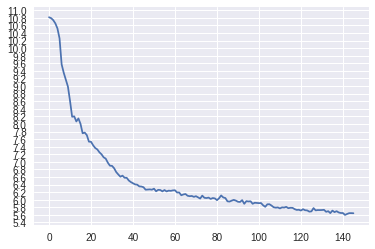

In [0]:
trainIters(encoder, decoder, n_iters, print_every=100, plot_every=100, learning_rate=learning_rate)

In [0]:
torch.save(encoder.state_dict(), folder_path + 'encoder2.pt')
torch.save(decoder.state_dict(), folder_path + 'decoder2.pt')

Training Model: Nov. 28th

In [0]:
# Configure models
hidden_size = 500
layers = 2
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iters = 10000

encoder2 = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder2 = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)
encoder2.load_state_dict(torch.load(folder_path + "encoder2.pt"))
decoder2.load_state_dict(torch.load(folder_path +"decoder2.pt"))

1m 10s (- 115m 59s) (100 1%) 5.5975
2m 20s (- 114m 32s) (200 2%) 5.5513
3m 30s (- 113m 15s) (300 3%) 5.5141
4m 39s (- 111m 56s) (400 4%) 5.5060
5m 49s (- 110m 49s) (500 5%) 5.5657
7m 0s (- 109m 42s) (600 6%) 5.5435
8m 10s (- 108m 35s) (700 7%) 5.5424
9m 20s (- 107m 23s) (800 8%) 5.4890
10m 30s (- 106m 17s) (900 9%) 5.5470
11m 41s (- 105m 11s) (1000 10%) 5.5296
12m 51s (- 104m 5s) (1100 11%) 5.5616
14m 2s (- 102m 57s) (1200 12%) 5.5474
15m 12s (- 101m 48s) (1300 13%) 5.5131
16m 23s (- 100m 39s) (1400 14%) 5.5158
17m 33s (- 99m 29s) (1500 15%) 5.4853
18m 43s (- 98m 20s) (1600 16%) 5.6163
19m 54s (- 97m 9s) (1700 17%) 5.5137
21m 4s (- 96m 1s) (1800 18%) 5.5727
22m 15s (- 94m 51s) (1900 19%) 5.5330
23m 25s (- 93m 41s) (2000 20%) 5.5151
24m 35s (- 92m 32s) (2100 21%) 5.6084
25m 46s (- 91m 22s) (2200 22%) 5.5317
26m 56s (- 90m 12s) (2300 23%) 5.5578
28m 6s (- 89m 1s) (2400 24%) 5.5048
29m 17s (- 87m 52s) (2500 25%) 5.5931
30m 27s (- 86m 41s) (2600 26%) 5.5273
31m 38s (- 85m 32s) (2700 27%) 5

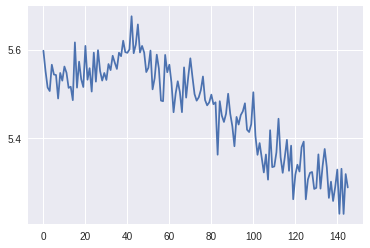

In [0]:
trainIters(encoder2, decoder2, n_iters, print_every=100, plot_every=100, learning_rate=learning_rate)

In [0]:
torch.save(encoder2.state_dict(), folder_path + 'encoder3.pt')
torch.save(decoder2.state_dict(), folder_path + 'decoder3.pt')

Training Model: Nov 30th

In [0]:
# Configure models
hidden_size = 500
layers = 2
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iters = 10000

encoder3 = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder3 = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)
encoder3.load_state_dict(torch.load(folder_path + "encoder3.pt"))
decoder3.load_state_dict(torch.load(folder_path +"decoder3.pt"))

1m 12s (- 119m 54s) (100 1%) 5.3020
2m 25s (- 118m 30s) (200 2%) 5.2259
3m 37s (- 117m 12s) (300 3%) 5.2173
4m 49s (- 115m 54s) (400 4%) 5.1294
6m 2s (- 114m 41s) (500 5%) 5.1952
7m 14s (- 113m 29s) (600 6%) 5.2293
8m 27s (- 112m 19s) (700 7%) 5.2073
9m 40s (- 111m 10s) (800 8%) 5.2156
10m 52s (- 109m 58s) (900 9%) 5.2079
12m 5s (- 108m 47s) (1000 10%) 5.1818
13m 17s (- 107m 34s) (1100 11%) 5.1819
14m 30s (- 106m 21s) (1200 12%) 5.1847
15m 42s (- 105m 9s) (1300 13%) 5.1598
16m 55s (- 103m 58s) (1400 14%) 5.2264
18m 8s (- 102m 47s) (1500 15%) 5.1932
19m 20s (- 101m 33s) (1600 16%) 5.0898
20m 33s (- 100m 21s) (1700 17%) 5.1719
21m 45s (- 99m 8s) (1800 18%) 5.1086
22m 58s (- 97m 56s) (1900 19%) 5.1683
24m 11s (- 96m 44s) (2000 20%) 5.2070
25m 23s (- 95m 30s) (2100 21%) 5.1358
26m 35s (- 94m 17s) (2200 22%) 5.1514
27m 47s (- 93m 4s) (2300 23%) 5.0986
29m 0s (- 91m 51s) (2400 24%) 5.1812
30m 13s (- 90m 39s) (2500 25%) 5.1921
31m 25s (- 89m 26s) (2600 26%) 5.1287
32m 38s (- 88m 14s) (2700 27

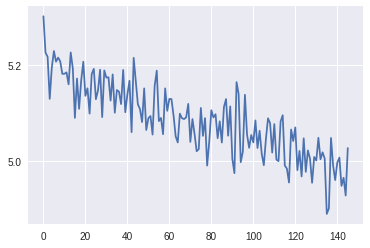

In [0]:
trainIters(encoder3, decoder3, n_iters, print_every=100, plot_every=100, learning_rate=learning_rate)

In [0]:
torch.save(encoder3.state_dict(), folder_path + 'encoder3.pt')
torch.save(decoder3.state_dict(), folder_path + 'decoder3.pt')

1m 13s (- 120m 44s) (100 1%) 4.9841
2m 26s (- 119m 21s) (200 2%) 4.9753
3m 39s (- 118m 3s) (300 3%) 4.9653
4m 51s (- 116m 41s) (400 4%) 4.9541
6m 4s (- 115m 29s) (500 5%) 4.9803
7m 17s (- 114m 15s) (600 6%) 4.9509
8m 30s (- 112m 59s) (700 7%) 4.9517
9m 42s (- 111m 42s) (800 8%) 4.9471
10m 55s (- 110m 29s) (900 9%) 5.0089
12m 8s (- 109m 13s) (1000 10%) 4.9203
13m 20s (- 107m 59s) (1100 11%) 4.9020
14m 32s (- 106m 41s) (1200 12%) 4.9097
15m 44s (- 105m 22s) (1300 13%) 4.9214
16m 56s (- 104m 3s) (1400 14%) 4.9448
18m 8s (- 102m 47s) (1500 15%) 4.9365
19m 20s (- 101m 33s) (1600 16%) 4.9928
20m 32s (- 100m 19s) (1700 17%) 4.9277
21m 45s (- 99m 5s) (1800 18%) 4.8891
22m 56s (- 97m 49s) (1900 19%) 4.9300
24m 8s (- 96m 35s) (2000 20%) 4.8954
25m 20s (- 95m 20s) (2100 21%) 4.8914
26m 32s (- 94m 6s) (2200 22%) 4.9192
27m 44s (- 92m 52s) (2300 23%) 4.9777
28m 56s (- 91m 39s) (2400 24%) 5.0269
30m 8s (- 90m 26s) (2500 25%) 4.9145
31m 20s (- 89m 13s) (2600 26%) 4.9308
32m 33s (- 88m 0s) (2700 27%) 

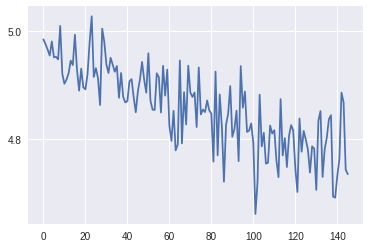

In [0]:
trainIters(encoder3, decoder3, n_iters, print_every=100, plot_every=100, learning_rate=learning_rate)

Testing model on validation dataset. Dec 1st

In [34]:
# Configure models
hidden_size = 500
layers = 2
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iters = 10000

encoder3 = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder3 = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)
encoder3.load_state_dict(torch.load(folder_path + "/encoder3.pt",map_location='cpu'))
decoder3.load_state_dict(torch.load(folder_path +"/decoder3.pt",map_location='cpu'))

In [35]:
# Set to not-training mode to disable dropout
encoder3.train(False)
decoder3.train(False)

running_loss = 0
for l, (input_var,input_data_len,output_var,output_data_len) in enumerate(val_loader):
    input_batch = input_var.transpose(0,1).to(device)
    output_batch = output_var.transpose(0,1).to(device)
    encoder_outputs, encoder_hidden = encoder3(input_batch, input_data_len, None)
  
    max_target_length = MAX_LENGTH
    # Prepare decoder input and outputs
    decoder_input = Variable(torch.LongTensor([SOS_token] * BATCH_SIZE)).to(device)
    decoder_hidden = encoder_hidden[:decoder3.n_layers] # Use last (forward) hidden state from encoder
    all_decoder_outputs = Variable(torch.zeros(max_target_length, BATCH_SIZE, decoder3.output_size)).to(device)
  
    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, decoder_hidden = decoder3(
        decoder_input, decoder_hidden
    )
        
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input
        all_decoder_outputs[t] = decoder_output # Store this step's outputs
    
    # Test masked cross entropy loss
    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(),
        output_batch.transpose(0, 1).contiguous(),
        output_data_len)
    running_loss += loss

In [0]:
running_loss

tensor(5.5396, device='cuda:0', grad_fn=<DivBackward1>)

Calculate Bleu Score

In [62]:
from typing import List
from collections import Counter, namedtuple
from itertools import zip_longest

def tokenize_13a(line):
    """
    Tokenizes an input line using a relatively minimal tokenization that is however equivalent to mteval-v13a, used by WMT.
    :param line: a segment to tokenize
    :return: the tokenized line
    """

    norm = line

    # language-independent part:
    norm = norm.replace('<skipped>', '')
    norm = norm.replace('-\n', '')
    norm = norm.replace('\n', ' ')
    norm = norm.replace('&quot;', '"')
    norm = norm.replace('&amp;', '&')
    norm = norm.replace('&lt;', '<')
    norm = norm.replace('&gt;', '>')
    
    
        # language-dependent part (assuming Western languages):
    norm = " {} ".format(norm)
    norm = re.sub(r'([\{-\~\[-\` -\&\(-\+\:-\@\/])', ' \\1 ', norm)
    norm = re.sub(r'([^0-9])([\.,])', '\\1 \\2 ', norm)  # tokenize period and comma unless preceded by a digit
    norm = re.sub(r'([\.,])([^0-9])', ' \\1 \\2', norm)  # tokenize period and comma unless followed by a digit
    norm = re.sub(r'([0-9])(-)', '\\1 \\2 ', norm)  # tokenize dash when preceded by a digit
    norm = re.sub(r'\s+', ' ', norm)  # one space only between words
    norm = re.sub(r'^\s+', '', norm)  # no leading space
    norm = re.sub(r'\s+$', '', norm)  # no trailing space

    return norm

def corpus_bleu(sys_stream, ref_streams, smooth='exp', smooth_floor=0.0, force=False, lowercase=False,
                 use_effective_order=False):
    """Produces BLEU scores along with its sufficient statistics from a source against one or more references.
    :param sys_stream: The system stream (a sequence of segments)
    :param ref_streams: A list of one or more reference streams (each a sequence of segments)
    :param smooth: The smoothing method to use
    :param smooth_floor: For 'floor' smoothing, the floor to use
    :param force: Ignore data that looks already tokenized
    :param lowercase: Lowercase the data
    :param tokenize: The tokenizer to use
    :return: a BLEU object containing everything you'd want
    """

    # Add some robustness to the input arguments
    if isinstance(sys_stream, str):
        sys_stream = [sys_stream]
    if isinstance(ref_streams, str):
        ref_streams = [[ref_streams]]

    sys_len = 0
    ref_len = 0

    correct = [0 for n in range(NGRAM_ORDER)]
    total = [0 for n in range(NGRAM_ORDER)]
    

    # look for already-tokenized sentences
    tokenized_count = 0
    
    fhs = [sys_stream] + ref_streams
    for lines in zip_longest(*fhs):
        if None in lines:
            raise EOFError("Source and reference streams have different lengths!")

        if lowercase:
            lines = [x.lower() for x in lines]
            
        tokenize= 'tokenize_13a'    

        if not (force or tokenize == 'none') and lines[0].rstrip().endswith(' .'):
            tokenized_count += 1

            if tokenized_count == 100:
                logging.warning('That\'s 100 lines that end in a tokenized period (\'.\')')
                logging.warning('It looks like you forgot to detokenize your test data, which may hurt your score.')
                logging.warning('If you insist your data is detokenized, or don\'t care, you can suppress this message with \'--force\'.')

        output, *refs = [tokenize_13a(x.rstrip()) for x in lines]
        

        ref_ngrams, closest_diff, closest_len = ref_stats(output, refs)
        
        sys_len += len(output.split())
        ref_len += closest_len

        sys_ngrams = extract_ngrams(output)
        for ngram in sys_ngrams.keys():
            n = len(ngram.split())
            correct[n-1] += min(sys_ngrams[ngram], ref_ngrams.get(ngram, 0))
            total[n-1] += sys_ngrams[ngram]
            

    return compute_bleu(correct, total, sys_len, ref_len, smooth, smooth_floor, use_effective_order)
  
  
# n-gram order. Don't change this.
NGRAM_ORDER = 4

def compute_bleu(correct: List[int], total: List[int], sys_len: int, ref_len: int, smooth = 'none', smooth_floor = 0.01,
                 use_effective_order = False):
    """Computes BLEU score from its sufficient statistics. Adds smoothing.
    :param correct: List of counts of correct ngrams, 1 <= n <= NGRAM_ORDER
    :param total: List of counts of total ngrams, 1 <= n <= NGRAM_ORDER
    :param sys_len: The cumulative system length
    :param ref_len: The cumulative reference length
    :param smooth: The smoothing method to use
    :param smooth_floor: The smoothing value added, if smooth method 'floor' is used
    :param use_effective_order: Use effective order.
    :return: A BLEU object with the score (100-based) and other statistics.
    """

    precisions = [0 for x in range(NGRAM_ORDER)]

    smooth_mteval = 1.
    effective_order = NGRAM_ORDER
    for n in range(NGRAM_ORDER):
        if total[n] == 0:
            break

        if use_effective_order:
            effective_order = n + 1

        if correct[n] == 0:
            if smooth == 'exp':
                smooth_mteval *= 2
                precisions[n] = 100. / (smooth_mteval * total[n])
            elif smooth == 'floor':
                precisions[n] = 100. * smooth_floor / total[n]
        else:
            precisions[n] = 100. * correct[n] / total[n]

    # If the system guesses no i-grams, 1 <= i <= NGRAM_ORDER, the BLEU score is 0 (technically undefined).
    # This is a problem for sentence-level BLEU or a corpus of short sentences, where systems will get no credit
    # if sentence lengths fall under the NGRAM_ORDER threshold. This fix scales NGRAM_ORDER to the observed
    # maximum order. It is only available through the API and off by default

    brevity_penalty = 1.0
    if sys_len < ref_len:
        brevity_penalty = math.exp(1 - ref_len / sys_len) if sys_len > 0 else 0.0
        

    bleu = brevity_penalty * math.exp(sum(map(my_log, precisions[:effective_order])) / effective_order)

    return bleu 
  
def ref_stats(output, refs):
    ngrams = Counter()
    closest_diff = None
    closest_len = None
    for ref in refs:
        tokens = ref.split()
        reflen = len(tokens)
        diff = abs(len(output.split()) - reflen)
        if closest_diff is None or diff < closest_diff:
            closest_diff = diff
            closest_len = reflen
        elif diff == closest_diff:
            if reflen < closest_len:
                closest_len = reflen

        ngrams_ref = extract_ngrams(ref)
        for ngram in ngrams_ref.keys():
            ngrams[ngram] = max(ngrams[ngram], ngrams_ref[ngram])

    return ngrams, closest_diff, closest_len
  

def extract_ngrams(line, min_order=1, max_order=NGRAM_ORDER) -> Counter:
    """Extracts all the ngrams (1 <= n <= NGRAM_ORDER) from a sequence of tokens.
    :param line: a segment containing a sequence of words
    :param max_order: collect n-grams from 1<=n<=max
    :return: a dictionary containing ngrams and counts
    """

    ngrams = Counter()
    tokens = line.split()
    for n in range(min_order, max_order + 1):
        for i in range(0, len(tokens) - n + 1):
            ngram = ' '.join(tokens[i: i + n])
            ngrams[ngram] += 1

    return ngrams  
  


def my_log(num):
    """
    Floors the log function
    :param num: the number
    :return: log(num) floored to a very low number
    """

    if num == 0.0:
        return -9999999999
    return math.log(num)
  


In [59]:
def evaluate_batch(loader, encoder, decoder):
    
    decoded_sentences = []
    actual_sentences = []
    
    for i, (source, lengths1, target, lengths2) in enumerate(loader):
        #iterate over batch
        
        for n in range(len(source)):
            # Go sentence by sentence
            
            decoded, actual = evaluate(encoder, decoder, source[n].unsqueeze(0), lengths1[n], target[n])
            decoded_sentences.append(decoded)
            actual_sentences.append(actual)
            
    return decoded_sentences, actual_sentences


def evaluate_bleu(translation_list, reference_list):
    
    return corpus_bleu(translation_list, [reference_list])

In [67]:
class BeamSearchNode(object):
    def __init__(self, hiddenstate, previousNode, wordId, logProb, length):
        '''
        :param hiddenstate:
        :param previousNode:
        :param wordId:
        :param logProb:
        :param length:
        '''
        self.h = hiddenstate
        self.prevNode = previousNode
        self.wordid = wordId
        self.logp = logProb
        self.leng = length


In [68]:
def beam_decode(target_tensor, decoder_hiddens, encoder_outputs=None):
    '''
    :param target_tensor: target indexes tensor of shape [B, T] where B is the batch size and T is the maximum length of the output sentence
    :param decoder_hidden: input tensor of shape [1, B, H] for start of the decoding
    :param encoder_outputs: if you are using attention mechanism you can pass encoder outputs, [T, B, H] where T is the maximum length of input sentence
    :return: decoded_batch
    '''

    beam_width = 10
    topk = 1  # how many sentence do you want to generate
    decoded_batch = []

    # decoding goes sentence by sentence
    for idx in range(target_tensor.size(0)):
        if isinstance(decoder_hiddens, tuple):  # LSTM case
            decoder_hidden = (decoder_hiddens[0][:,idx, :].unsqueeze(0),decoder_hiddens[1][:,idx, :].unsqueeze(0))
        else:
            decoder_hidden = decoder_hiddens[:, idx, :].unsqueeze(0)
        encoder_output = encoder_outputs[:,idx, :].unsqueeze(1)

        # Start with the start of the sentence token
        decoder_input = torch.LongTensor([[SOS_token]], device=device)

        # Number of sentence to generate
        endnodes = []
        number_required = min((topk + 1), topk - len(endnodes))

        # starting node -  hidden vector, previous node, word id, logp, length
        node = BeamSearchNode(decoder_hidden, None, decoder_input, 0, 1)
        nodes = PriorityQueue()

        # start the queue
        nodes.put((-node.eval(), node))
        qsize = 1

        # start beam search
        while True:
            # give up when decoding takes too long
            if qsize > 2000: break

            # fetch the best node
            score, n = nodes.get()
            decoder_input = n.wordid
            decoder_hidden = n.h

            if n.wordid.item() == EOS_token and n.prevNode != None:
                endnodes.append((score, n))
                # if we reached maximum # of sentences required
                if len(endnodes) >= number_required:
                    break
                else:
                    continue

            # decode for one step using decoder
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output)

            # PUT HERE REAL BEAM SEARCH OF TOP
            log_prob, indexes = torch.topk(decoder_output, beam_width)
            nextnodes = []

            for new_k in range(beam_width):
                decoded_t = indexes[0][new_k].view(1, -1)
                log_p = log_prob[0][new_k].item()

                node = BeamSearchNode(decoder_hidden, n, decoded_t, n.logp + log_p, n.leng + 1)
                score = -node.eval()
                nextnodes.append((score, node))

            # put them into queue
            for i in range(len(nextnodes)):
                score, nn = nextnodes[i]
                nodes.put((score, nn))
                # increase qsize
            qsize += len(nextnodes) - 1

        # choose nbest paths, back trace them
        if len(endnodes) == 0:
            endnodes = [nodes.get() for _ in range(topk)]

        utterances = []
        for score, n in sorted(endnodes, key=operator.itemgetter(0)):
            utterance = []
            utterance.append(n.wordid)
            # back trace
            while n.prevNode != None:
                n = n.prevNode
                utterance.append(n.wordid)

            utterance = utterance[::-1]
            utterances.append(utterance)

        decoded_batch.append(utterances)

    return decoded_batch

In [41]:
# Configure models
hidden_size = 500
layers = 2
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iters = 10000

encoder3 = EncoderRNN(weights_matrix_zh, train_input_lang.n_words, hidden_size, n_layers = layers).to(device)
decoder3 = DecoderRNN(weights_matrix_eng, hidden_size, train_output_lang.n_words, n_layers = layers).to(device)
encoder3.load_state_dict(torch.load(folder_path + "/encoder3.pt",map_location='cpu'))
decoder3.load_state_dict(torch.load(folder_path +"/decoder3.pt",map_location='cpu'))

In [60]:
decoded, actual = evaluate_batch(val_loader, encoder3, decoder3)

for i in zip(decoded, actual):
    if i == 10:
        break
    print('\n')
    print('Expected:', i[1])
    print('Actual:' ,i[0])

/Users/Stella/miniconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.




Expected:  She retired two years ago only to turn our house into a school for girls and women in our neighborhood .
Actual:  She was years to years ago ago .


Expected:  There was a big smile on his face which was unusual then because the news mostly depressed him .
Actual:  He s .


Expected:  And my father that s him he was the first ever in his family to receive an education .
Actual:  My mother was my mother .


Expected:  We all knew we were risking our lives the teacher the students and our parents .
Actual:  We all all all all all .


Expected:  When I was I remember waking up one morning to the sound of joy in my house .
Actual:  I was years to . . . .


Expected:  I didn t know what it meant but I could see that my father was very very happy .
Actual:  I don t know it .


Expected:  You see I was six when the Taliban took over Afghanistan and made it illegal for girls to go to school .
Actual:  My father was to to . . .


Expected:  Each day we took a different route so tha

Actual:  But some of some of a . .


Expected:  But there s also something funny going on here .
Actual:  And some things are things things are things .


Expected:  The ripples should be moving towards us .
Actual:  But they are are going to be .


Expected:  So they kill the lions .
Actual:  So they would to to . .


Expected:  So Superman can fly .
Actual:  Now now a .


Expected:  Can we see it in full D ?
Actual:  We can have a . . .


Expected:  They kill our livestock .
Actual:  And we re we we we us us . .


Expected:  What s going on here ?
Actual:  What ?


Expected:  She had a lot of her animals being killed by lions and she asked me if I could put the lights for her .
Actual:  She was a . .


Expected:  Ashe . It means in my language thank you very much .
Actual:  Thank you very much .


Expected:  Since now I ve set up seven homes around my community and they re really working .
Actual:  Now .


Expected:  So one night I was walking around the with a torch and that day the

Expected:  It s a porous asphalt like I said so you have only a small amount of binder between the stones .
Actual:  This is the the .


Expected:  Then if you drive over the road you take out the aggregates what we just saw here .
Actual:  And if this this is this this ?


Expected:  Then you need a machine like you see here that you can use for cooking an induction machine .
Actual:  You need to go .


Expected:  I thanked him with all my heart and I asked him Why are you helping me ?
Actual:  Thank . they


Expected:  Because it s very hollow all the noise will disappear so it s a very silent road .
Actual:  Because there it s many lot of them .


Expected:  It also has disadvantages of course and the disadvantage of this road is that can occur .
Actual:  And it it it it it s .


Expected:  of course that can become a problem but we have a solution .
Actual:  .


Expected:  If we can make this material self healing then probably we have a solution .
Actual:  So if we can be it it wo

In [65]:
evaluate_bleu(decoded, actual)

1.1691207505793362